# Problem 2: Autoencoder Neural Network


Homework 4: Feed-foward Neural Network and Autoencoder Network Modification and Comparison <br>
Due Date: 11/29/22 <br>
Creator: Cat Luong (luongcn@mail.uc.edu)

In [307]:
import random as rand
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [308]:
training_set = np.loadtxt('training_set.txt', dtype=float)
test_set = np.loadtxt('test_set.txt', dtype=float)
np.random.shuffle(training_set)

In [309]:
def get_train_data(training_set): # Get the train data from training set
    train_data = [list(x[0:784]) for i, x in enumerate(training_set)]
    np_data = np.array(train_data)
    return np_data

def get_labels(training_set): # Get the label from training set
    labels = [int(x[-1]) for i, x in enumerate(training_set)]
    np_labels = np.array(labels)
    return np_labels

def get_AE_data(train_test_files, validate_files): # Get the data used for training of the Autoencoder
    train = []
    test = []
    validate = []
    for f in train_test_files: 
        temp_file = np.loadtxt(str(f), dtype=float)
        train += [list(x[0:784]) for i, x in enumerate(temp_file)][0:400]
        test  += [list(x[0:784]) for i, x in enumerate(temp_file)][400:500]
    for f_valid in validate_files:
        temp_file = np.loadtxt(str(f_valid), dtype=float)
        validate += [list(x[0:784]) for i, x in enumerate(temp_file)]
    return np.asarray(train), np.asarray(test), np.asarray(validate)

def get_AE_labels(train_test_files, validate_files): # Get the labels used for plotting later on.
    train_labels = []
    test_labels = []
    validate_labels = []
    for f in train_test_files: 
        temp_file = np.loadtxt(str(f), dtype=float)
        train_labels += [int(x[-1]) for i, x in enumerate(temp_file)][0:400]
        test_labels  += [int(x[-1]) for i, x in enumerate(temp_file)][400:500]
    for f_valid in validate_files:
        temp_file = np.loadtxt(str(f_valid), dtype=float)
        validate_labels += [int(x[-1]) for i, x in enumerate(temp_file)]
    return np.asarray(train_labels), np.asarray(test_labels), np.asarray(validate_labels)


In [310]:
# Parameters initialization
input_neurons = 784 # Corresponds to 28 x 28 image
hidden_neurons = 150 # Between 100 and 200 neurons
output_neurons = 784  # This time the output layer will have the same number of neurons as the input layer
learning_rate = 0.01 # initialize learning rate used for calculation of weight change
momentum = 0.5 # Gradient descent with momentum, this was changed from 0.4 to 0.5
EPOCHS = 1000 # Train on a certain number of EPOCHS

Make sure to specify that you are changing the biases update and the biases intialization!!

In [311]:
class AutoEncoder():
    def __init__(self, input_neurons, hidden_neurons, output_neurons, learning_rate, momentum, EPOCHS): 
        # Set the hyperparemters for the Auto Encoder
        self.input_neurons = input_neurons
        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.bias1 = np.ones((1, self.hidden_neurons)) #initialize biases as arrays of ones
        self.bias2 = np.ones((1, self.output_neurons))
        # self.bias1 = np.array([np.random.uniform(0., 1., None) for _ in range(self.hidden_neurons)]) # I changed how I initialize the biases
        # self.bias2 = np.array([np.random.uniform(0., 1., None) for _ in range(self.output_neurons)]) # I changed how I intialize the biases
        self.epochs = EPOCHS

        # Use as place holders to update weight change
        self.pre_delta_w_1 = 0 
        self.pre_delta_w_2 = 0

        # Initialize weights using Xavier's intialization
        self.Wbar_1 = np.random.randn(self.hidden_neurons, self.input_neurons) * np.sqrt(1 / (self.hidden_neurons + self.input_neurons))# Weights for the input layer and the hidden layer
        self.Wbar_2 = np.random.randn(self.output_neurons, self.hidden_neurons) * np.sqrt(1 / (self.output_neurons + self.hidden_neurons))# Weights for the hidden layer and the output layers

    def get_weights(self):
        return self.Wbar_1, self.Wbar_2
    
    def get_output(self):
        return self.yhat_2
    def get_hidden(self):
        return self.yhat_1
        
    def print_weights(self):
        print(f"The first set of weights is: \n{self.Wbar_1=}\n")
        print(f"The second set of weights is: \n{self.Wbar_2=}")

    def mean_weights(self):
        print(f"The mean of final weights 1 is: \n{self.Wbar_1.mean()}\n")
        print(f"The mean of final weights 2 is: \n{self.Wbar_2.mean()}")

    def normalize_biases(self):
        self.bias1 = np.asarray(np.sum(self.bias1, axis = 0))
        self.bias2 = np.asarray(np.sum(self.bias2, axis = 0))
    
    def NormalizeData(self, data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))

    def sigmoid(self, z): # Sigmoid: 1/(1 + e^-x)
        return 1.0/(1.0 + np.exp(-z))

    def deri_sigmoid(self, z): # Derivative of Sigmoid
        return self.sigmoid(z) * (1 - self.sigmoid(z))
    
    def forward_prop(self, X): # Forward Propagation 
        self.z1 = np.dot(X, self.Wbar_1.T) # Net input 1
        self.yhat_1 = self.sigmoid(self.z1) # activation function for the hidden layer
        self.z2 = np.dot(self.yhat_1, self.Wbar_2.T) + self.bias2 # Net input 2 
        self.yhat_2 = self.sigmoid(self.z2) # activation function for the output layer.
    
    def normalize_output(self):
        self.yhat_2 = self.NormalizeData(self.yhat_2)

    def back_prop(self, X, epoch): # Define Back Propagation, I removed the bias for the first layer to improve the efficiency
        self.output_errors = (X - self.yhat_2)

        self.d_output = self.output_errors * self.deri_sigmoid(self.yhat_2) # 4000 x 784
        self.d_hidden = self.deri_sigmoid(self.yhat_1) * np.dot(self.d_output, self.Wbar_2) # 4000 x 150

        delta_w_2 = self.learning_rate*np.dot(np.transpose(self.yhat_1), self.d_output).T # Weights change for the second layer (hidden - output)
        delta_w_1 = self.learning_rate*np.dot(np.transpose(X), self.d_hidden).T # Weights change for the first layer (input - hidden)
        delta_bias2 = (self.learning_rate*self.d_output)
        delta_bias1 = (self.learning_rate*self.d_hidden)
    
        if(epoch >= 1): # run after epoch = 1 according to the lecture 
            delta_w_2 += (self.momentum*self.pre_delta_w_2) # => THIS IS TO KNOW HOW THE CHANGES ARE UPDATED
            delta_w_1 += (self.momentum*self.pre_delta_w_1)
            delta_bias2 += (self.momentum*self.pre_delta_bias2)
            delta_bias1 += (self.momentum*self.pre_delta_bias1)
            self.Wbar_2 = self.Wbar_2 + delta_w_2 # for (hidden - output)
            self.Wbar_1 = self.Wbar_1 + delta_w_1 # for (input - output)
            self.bias2 = self.bias2 + np.mean(delta_bias2)
            self.bias1 = self.bias1 + np.mean(delta_bias1, axis = 0)

        self.pre_delta_w_2 = delta_w_2 # Keep this value for update of weights change
        self.pre_delta_w_1 = delta_w_1 # Same
        self.pre_delta_bias2 = delta_bias2
        self.pre_delta_bias1 = delta_bias1


Some additional functions I wrote to train the model:

In [312]:
    # The classify() and output() functions are for the winner-takes-all method
    
    def classify(y): # Classify to see the output is which number
        output_lst = []
        for o in y:
            max_output = np.amax(o)
            for i, j in enumerate(o): 
                if j == max_output:
                    output_lst.append(i)
        return np.asarray(output_lst)
        
    def output(y): # Output the index of the entry with the highest value in the output
        max_out = np.amax(y)
        for i, j in enumerate(y): 
                if j == max_out:
                    return i

    def one_hot_encode(y_labels): # onehot encode the outputs
        one_hot_labels = np.zeros((y_labels.size, output_neurons))
        one_hot_labels[np.arange(y_labels.size), y_labels] = 1 
        out_hot_labels = one_hot_labels.T
        return one_hot_labels
    
    def error_fractions(y, yhat): # Get the error fraction
        ERRORS = 0
        yhat_one = one_hot_encode(np.int_(classify(yhat)))
        for i, x in enumerate(y):
            for j in range(len(x)):
                if (y[i][j] != yhat_one[i][j]):
                    ERRORS += 1
                    break
        return (ERRORS/len(y)) * 100
    
    def loss_errors(y, yhat): # Get the loss error 
        error = 0.0
        error += (1.0/2.0 * np.sum((y - yhat)**2))
        return error

    def confusion_matrix(y, yhat): # Create a 10 x 10 confusion matrix
        confuse = np.zeros((10,10))
        for i, x in enumerate(y):
            y_output = int(output(y[i]))
            yhat_output = int(output(yhat[i]))
            confuse[y_output][yhat_output] += 1
        return confuse
    
    def get_digits_index(digit, list): # Get the indices of the digits
            indices = []
            for idx, value in enumerate(list):
                if value == digit:
                    indices.append(idx)
            return indices

### Train The Auto Encoder

#### Get the data for training

In [313]:
files = ['0.txt', '1.txt', '2.txt', '3.txt', '4.txt', '5.txt', '6.txt', '7.txt', '8.txt', '9.txt']
train_test_files = files[0:5]
validate_files = files[5:]
# Get train, test, validate set. (train + test) is from 0 to 4, and validate set is 5 to 9. 
train, test, validate = get_AE_data(train_test_files, validate_files)
train_labels, test_labels, validate_labels = get_AE_labels(train_test_files, validate_files)

print("The data shapes: ")
print(train.shape)
print(test.shape)
print(validate.shape)
print("\nThe labels shapes:")
print(train_labels.shape)
print(test_labels.shape)
print(validate_labels.shape)

The data shapes: 
(2000, 784)
(500, 784)
(2500, 784)

The labels shapes:
(2000,)
(500,)
(2500,)


In [314]:
nn = AutoEncoder(input_neurons, hidden_neurons, output_neurons, learning_rate, momentum, EPOCHS)

In [315]:
ERROR_train = []
ERROR_epochs = []

In [316]:
for epoch in range(EPOCHS):
        nn.forward_prop(train)
        if epoch % 10 == 0:
            print(f"The ERRORS for epoch {epoch} is: {loss_errors(train, nn.get_output())}")
            ERROR_train.append(loss_errors(train, nn.get_output()))
            ERROR_epochs.append(epoch)
        nn.back_prop(train, epoch)
 


The ERRORS for epoch 0 is: 360839.6836711662


C:\Users\Admin\AppData\Local\Temp\ipykernel_18456\2483448277.py:47: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0 + np.exp(-z))


The ERRORS for epoch 10 is: 117602.41295298627
The ERRORS for epoch 20 is: 87735.24019748381
The ERRORS for epoch 30 is: 132052.6456808242
The ERRORS for epoch 40 is: 84561.21233640169
The ERRORS for epoch 50 is: 62334.417635602396
The ERRORS for epoch 60 is: 45460.80062470403
The ERRORS for epoch 70 is: 41076.57897673056
The ERRORS for epoch 80 is: 36652.3930140087
The ERRORS for epoch 90 is: 33329.49631122822
The ERRORS for epoch 100 is: 30526.896712580234
The ERRORS for epoch 110 is: 29499.194281041782
The ERRORS for epoch 120 is: 28113.818711032713
The ERRORS for epoch 130 is: 26501.65173773118
The ERRORS for epoch 140 is: 26352.6818045982
The ERRORS for epoch 150 is: 25028.274579911376
The ERRORS for epoch 160 is: 24960.241566452456
The ERRORS for epoch 170 is: 24471.71787563007
The ERRORS for epoch 180 is: 24285.565273819066
The ERRORS for epoch 190 is: 23443.53218393582
The ERRORS for epoch 200 is: 23279.42129197578
The ERRORS for epoch 210 is: 22953.09557441077
The ERRORS for e

### Plot of Error Fraction over Time Series of Training Set

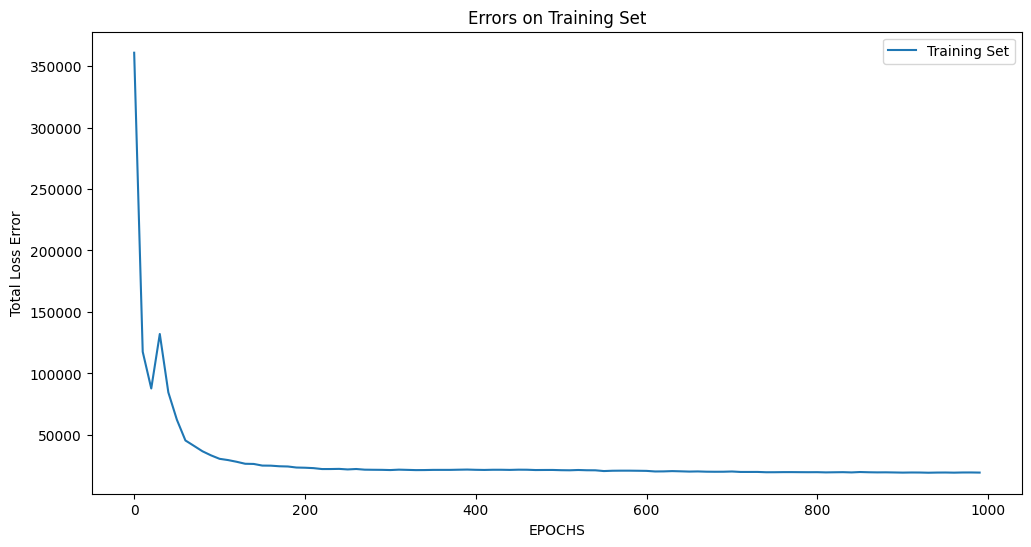

In [317]:
lst_errors = ERROR_train
labels = 'Training Set'
fig, axis = plt.subplots(1, 1, sharex=True, figsize=(12, 6))
plt.plot([i*10 for i in range(len(ERROR_epochs))], lst_errors, label=labels)
plt.title('Errors on Training Set')
plt.xlabel('EPOCHS')
plt.ylabel('Total Loss Error')
plt.legend(loc="upper right")
plt.savefig('problem2_error_fractions.png')
plt.show()

### Test the Outputs after Training

In [318]:
hidden_weights, output_weights = nn.get_weights()

In [319]:
print(hidden_weights.shape)
print(output_weights.shape)


(150, 784)
(784, 150)


In [320]:
rand_num = rand.randint(0, len(train) - 1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_18456\2483448277.py:47: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0 + np.exp(-z))


<AxesSubplot: >

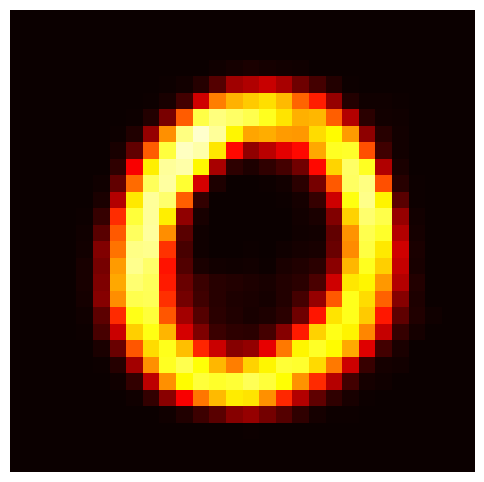

In [321]:
nn.forward_prop(train)
actual_output = nn.get_output()
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
sns.heatmap(actual_output[rand_num].reshape(28, 28).T, ax=ax, vmin=0, vmax=1, cmap = 'hot', yticklabels=False, xticklabels=False, cbar = False)

The outputed number should be number 0


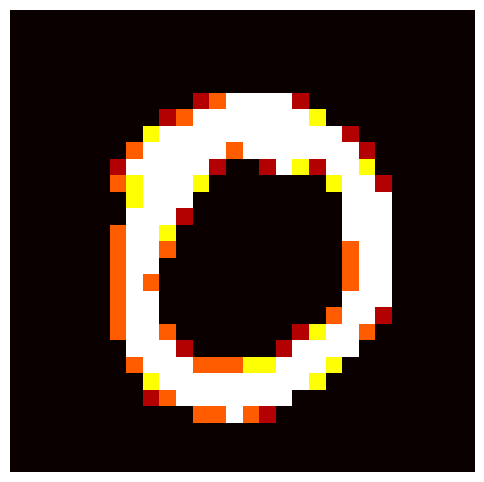

In [322]:
fig, ax0 = plt.subplots(1, 1, figsize = (6, 6))
sns.heatmap(train[rand_num].reshape(28, 28).T, ax=ax0, vmin=0, vmax=1, cmap = 'hot', yticklabels=False, xticklabels=False, cbar = False)
print(f"The outputed number should be number {train_labels[rand_num]}")

Generate image of a random weight in the two set of weights

<AxesSubplot: >

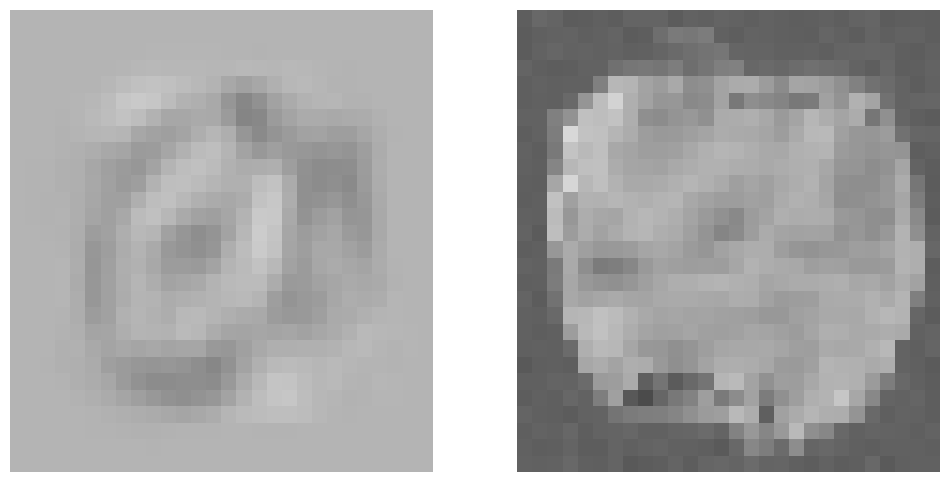

In [323]:
newshape = (28, 28)
norm_weights1 = (hidden_weights-np.min(hidden_weights))/(np.max(hidden_weights)-np.min(hidden_weights))
norm_weights2 = (output_weights-np.min(output_weights))/(np.max(output_weights)-np.min(output_weights))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
sns.heatmap(norm_weights1[149].reshape(28, 28).T, ax=ax1, vmin=0, vmax=1, cmap = 'gray', yticklabels=False, xticklabels=False, cbar = False)
sns.heatmap(norm_weights2.T[149].reshape(28, 28), ax=ax2, vmin=0, vmax=1, cmap = 'gray', yticklabels=False, xticklabels=False, cbar = False)

Test on the output on a random sample on the test set:

In [324]:
test_rand_num = rand.randint(0, len(test) - 1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_18456\2483448277.py:47: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0 + np.exp(-z))


<AxesSubplot: >

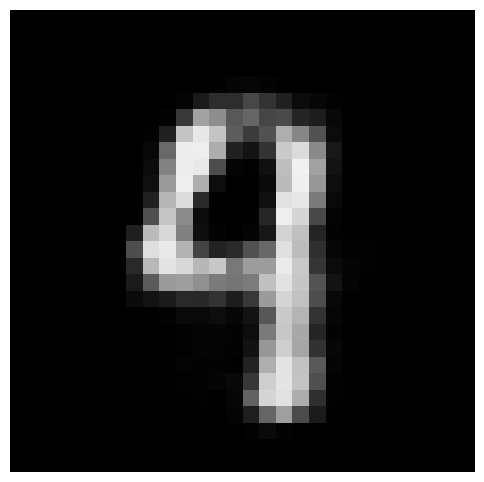

In [325]:
nn.forward_prop(test)
test_output = nn.get_output()
fig, ax3 = plt.subplots(1, 1, figsize = (6, 6))
sns.heatmap(test_output[test_rand_num].reshape(28, 28).T, ax=ax3, vmin=0, vmax=1, cmap = 'gray', yticklabels=False, xticklabels=False, cbar = False)

The outputed image should be number 4


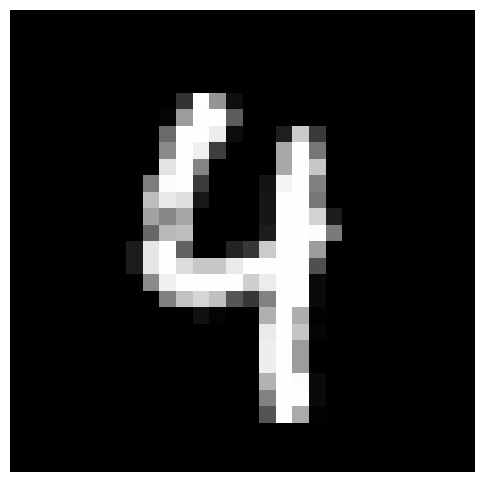

In [326]:
fig, ax4 = plt.subplots(1, 1, figsize = (6, 6))
sns.heatmap(test[test_rand_num].reshape(28, 28).T, ax=ax4, vmin=0, vmax=1, cmap = 'gray', yticklabels=False, xticklabels=False, cbar = False)
print(f"The outputed image should be number {test_labels[test_rand_num]}")

### Results on Bar Plots

#### Train Set

In [327]:
train_num_dct = {}
for i in range(5):
    train_num_dct[i] = get_digits_index(i, train_labels)

In [328]:
def get_error_digit(y, yhat, digit_list):
    error = 0
    for i in digit_list:
        error += (1.0/2.0 * np.sum(((y[i] - yhat[i])**2)))
    return error

In [329]:
ERROR_train = {}
for i in range(5):
    ERROR_train[i] = get_error_digit(train, actual_output, train_num_dct[i])
print(sum(ERROR_train.values()))


19503.373038247264


#### Test Set

In [330]:
test_num_dct = {}
for i in range(5):
    test_num_dct[i] = get_digits_index(i, test_labels)

In [331]:
ERROR_test = {}
for i in range(5):
    ERROR_test[i] = get_error_digit(test, test_output, test_num_dct[i])
print(ERROR_test)

{0: 1531.683435297141, 1: 428.83483818362686, 2: 1469.6127668848521, 3: 1252.9000815522506, 4: 1090.78272258622}


In [332]:
print(f"The final error on train set is {sum(ERROR_train.values())}")
print(f"The final error on the test set is {sum(ERROR_test.values())}")

The final error on train set is 19503.373038247264
The final error on the test set is 5773.81384450409


#### Train and Test Bar Plots

In [333]:
print(ERROR_train)

{0: 5379.797982433042, 1: 1573.5358331365028, 2: 4841.4980150972, 3: 4154.835857151062, 4: 3553.7053504294554}


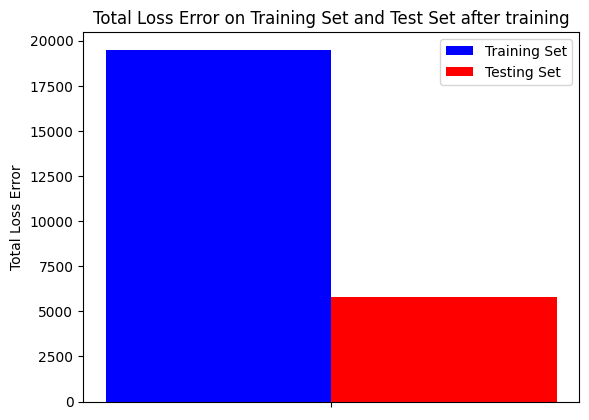

In [334]:
train_val = sum(ERROR_train.values()) 
test_val = sum(ERROR_test.values()) 

# Calculate optimal width
width = 0.3
indices = np.arange(1)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(indices, train_val, width, color='b', label='Training Set', align='edge')
ax.bar(indices + width, test_val, width, color='r', label='Testing Set', align='edge')
ax.legend()
ax.set_title('Total Loss Error on Training Set and Test Set after training')
ax.set_xticks(indices + width, (''))
ax.set_ylabel('Total Loss Error')
plt.savefig('problem2_loss.png')
plt.show()

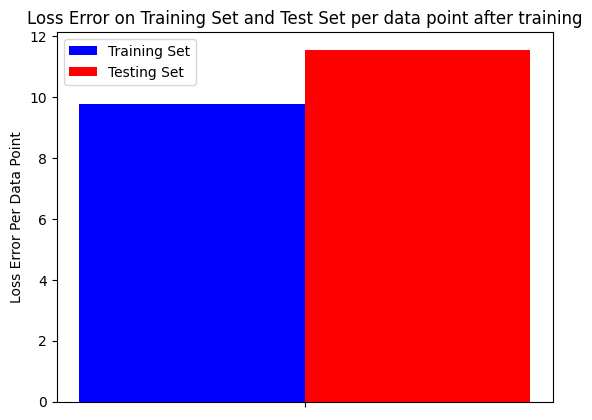

In [335]:
train_val = sum(ERROR_train.values()) / len(train)
test_val = sum(ERROR_test.values()) / len(test)

# Calculate optimal width
width = 0.3
indices = np.arange(1)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(indices, train_val, width, color='b', label='Training Set', align='edge')
ax.bar(indices + width, test_val, width, color='r', label='Testing Set', align='edge')
ax.legend()
ax.set_title('Loss Error on Training Set and Test Set per data point after training')
ax.set_xticks(indices + width, (''))
ax.set_ylabel('Loss Error Per Data Point')
plt.savefig('problem2_loss_point.png')
plt.show()

Plot the bar plot of Total Loss Error by digits in Training set and Test set

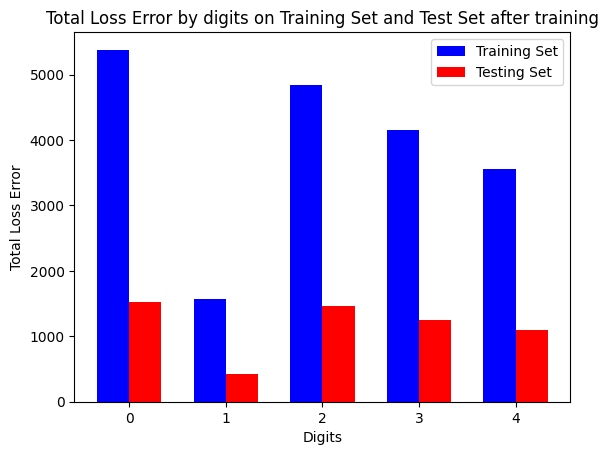

In [336]:
# Transform the train and test data into tuples
train_val = list(ERROR_train.values()) 
test_val = list(ERROR_test.values()) 
indices = list(ERROR_train.keys())

# Calculate optimal width
width = np.min(np.diff(indices))/3

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(indices-width, train_val, width, color='b', label='Training Set', align='edge')
ax.bar(indices, test_val, width, color='r', label='Testing Set', align='edge')
ax.legend()
ax.set_title('Total Loss Error by digits on Training Set and Test Set after training')
ax.set_xlabel('Digits')
ax.set_ylabel('Total Loss Error')
ax.set_xticks(indices)
plt.savefig('problem2_loss_digits.png')
plt.show()

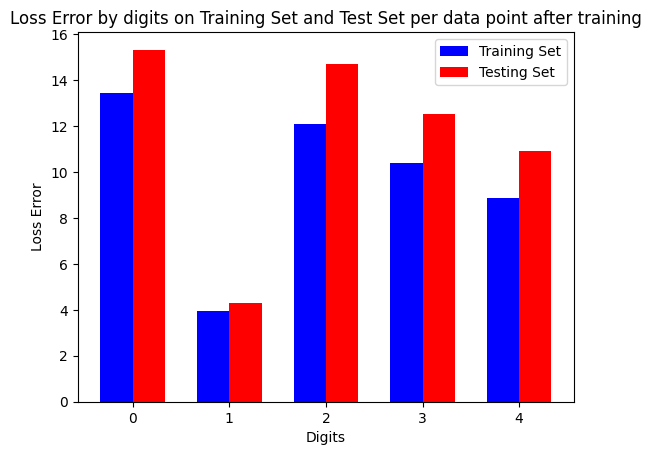

In [337]:
train_val = [x / 400 for x in list(ERROR_train.values())] 
test_val = [x / 100 for x in list(ERROR_test.values())] 
indices = list(ERROR_train.keys())

# Calculate optimal width
width = np.min(np.diff(indices))/3

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(indices-width, train_val, width, color='b', label='Training Set', align='edge')
ax.bar(indices, test_val, width, color='r', label='Testing Set', align='edge')
ax.legend()
ax.set_title('Loss Error by digits on Training Set and Test Set per data point after training')
ax.set_xlabel('Digits')
ax.set_ylabel('Loss Error')
ax.set_xticks(indices)
plt.savefig('problem2_loss_digits_point.png')
plt.show()

#### Validate Bar Plots

In [338]:
nn.forward_prop(validate)
validate_output = nn.get_output()

C:\Users\Admin\AppData\Local\Temp\ipykernel_18456\2483448277.py:47: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0 + np.exp(-z))


In [339]:
validate_num_dct = {}
for i in range(5, 10, 1):
    validate_num_dct[i] = get_digits_index(i, validate_labels)

In [340]:
ERROR_validate = {}
for i in range(5, 10, 1):
    ERROR_validate[i] = get_error_digit(validate, validate_output, validate_num_dct[i])
print(ERROR_validate)

{5: 10846.272958397294, 6: 10891.270499746242, 7: 8232.880358013488, 8: 10524.50677970401, 9: 7301.366881855201}


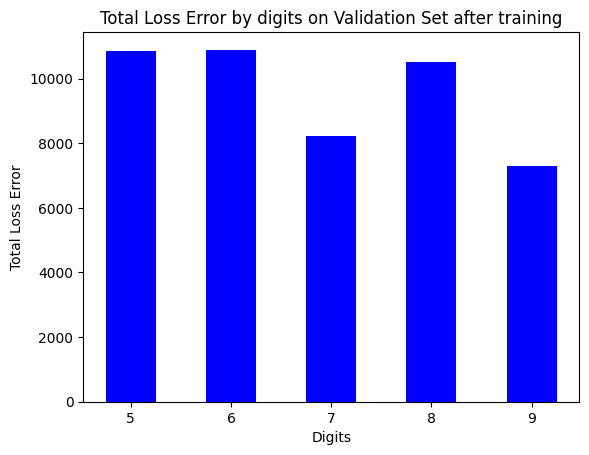

In [341]:
validate_val = list(ERROR_validate.values())
validate_indices = list(ERROR_validate.keys())

# Calculate optimal width
width = np.min(np.diff(validate_indices))/2

fig = plt.figure()
plt.bar(validate_indices - width/2, validate_val, width, color='b', label='Validation Set', align='edge')
plt.title('Total Loss Error by digits on Validation Set after training')
plt.xlabel('Digits')
plt.ylabel('Total Loss Error')
plt.xticks(validate_indices)
plt.savefig('problem2_validate_loss_digits.png')
plt.show()

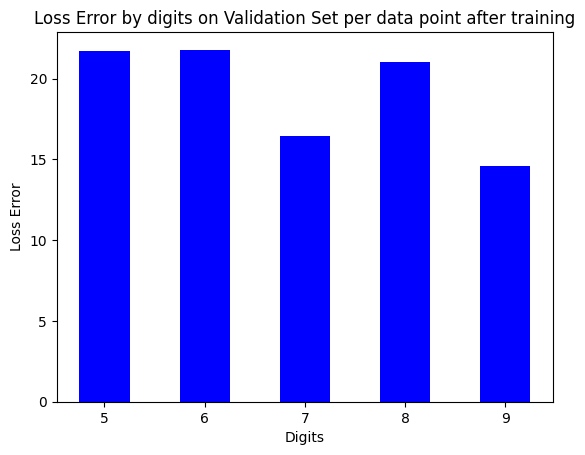

In [342]:
validate_val = [x / 500 for x in list(ERROR_validate.values())]
validate_indices = list(ERROR_validate.keys())

# Calculate optimal width
width = np.min(np.diff(validate_indices))/2

fig = plt.figure()
plt.bar(validate_indices - width/2, validate_val, width, color='b', label='Validation Set', align='edge')
plt.title('Loss Error by digits on Validation Set per data point after training')
plt.xlabel('Digits')
plt.ylabel('Loss Error')
plt.xticks(validate_indices)
plt.savefig('problem2_validate_loss_digit_point.png')
plt.show()

### Feature Selection

In [343]:
def get_random(num_output: int, num_random: int) -> list: #Generate certain random numbers
    lst_hidden = []
    num = rand.randint(0, num_output - 1)
    for i in range(num_random): 
        temp_num = num
        num = rand.randint(0, num_output - 1)
        if temp_num != num: 
            lst_hidden.append(temp_num)
    return lst_hidden

def check_duplicate(lst_hidden: list) -> bool: # Test to see if there are duplicates in random numbers, True means no and False means yes
    dup = set([x for x in lst_hidden if lst_hidden.count(x) > 1])
    return dup == set()


In [344]:
# Randomly select hidden neurons:
lst_hidden = get_random(hidden_neurons, num_random = 20)
while check_duplicate(lst_hidden) == False and lst_hidden != 20:
    lst_hidden = get_random(hidden_neurons, num_random = 20)
print(check_duplicate(lst_hidden))

True


In [345]:
len(lst_hidden)

20

In [346]:
nn.forward_prop(train)
hidden_output = nn.get_hidden()
AE_hidden_weights, AE_output_weights = nn.get_weights()

C:\Users\Admin\AppData\Local\Temp\ipykernel_18456\2483448277.py:47: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0 + np.exp(-z))


### Plot the features of the hidden neuron from Autoencoder and the FNN in Problem 1

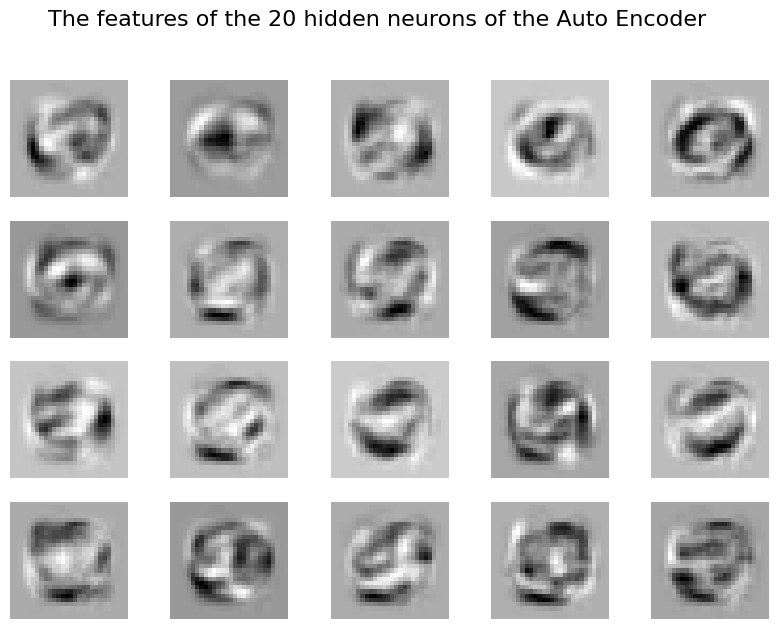

In [347]:
# Plot the features for the hidden output of the Auto Encoder in Problem 2
fig = plt.figure(figsize=(10, 7))
rows = 4
columns = 5
fig.suptitle("The features of the 20 hidden neurons of the Auto Encoder", fontsize = 16)
for i in range(len(lst_hidden)):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(AE_hidden_weights[lst_hidden[i]].reshape(28, 28), cmap ="gray")
    plt.axis('off')
plt.savefig('problem2_AE_features.png')
plt.show()

In [348]:
np.savetxt('AE_hidden_weights_modified.txt', AE_hidden_weights)

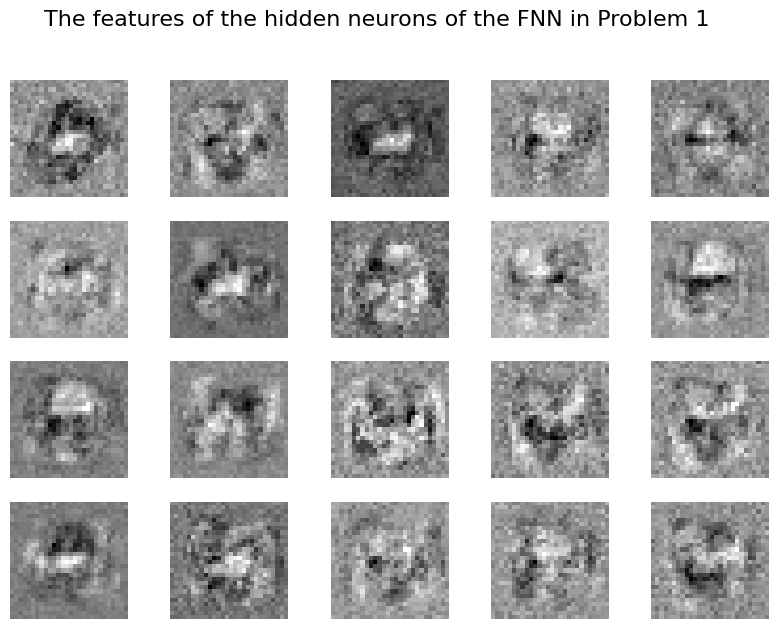

In [349]:
# Plot the features for the hidden output of the Feed-forward Neural Network in Problem 1
FNN_hidden_weights = np.loadtxt('FNN_hidden_weights.txt')
fig = plt.figure(figsize=(10, 7))
rows = 4
columns = 5
fig.suptitle('The features of the hidden neurons of the FNN in Problem 1', fontsize = 16)
for i in range(len(lst_hidden)):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(FNN_hidden_weights[lst_hidden[i]].reshape(28, 28), cmap ="gray")
    plt.axis('off')
plt.savefig('problem2_FNN_features.png')
plt.show()

### Sample Outputs

In [350]:
def get_output_test(test_dct: dict) -> dict: # Function Defined to get the indices for the digits of Training/Test Set
    test_random = {}
    for i in list(test_dct.keys()):
        test_random[i] = list(rand.sample(range(int(test_dct[i][0]), int(test_dct[i][-1])), 5))
    return test_random

def get_output_validate(validate_dct: dict) -> dict: # Function Defined to get the indices for the digits of Validation Set
    validate_random = {}
    for i in list(validate_dct.keys()):
        validate_random[i] = list(rand.sample(range(int(validate_dct[i][0]), int(validate_dct[i][-1])), 5))
    return validate_random

In [351]:
test_random = get_output_test(test_num_dct)
validate_random = get_output_validate(validate_num_dct)
total_random = {**test_random, **validate_random}

In [352]:
print("Indices of Test Images")
print(test_random)
print('\n')
print("Indices of Validate Images")
print(validate_random)
print('\n')
print("Indices of all the Images needed")
print(total_random)

Indices of Test Images
{0: [42, 49, 60, 34, 86], 1: [158, 149, 151, 178, 117], 2: [263, 295, 272, 267, 236], 3: [300, 369, 330, 316, 366], 4: [491, 494, 426, 489, 460]}


Indices of Validate Images
{5: [333, 198, 273, 475, 410], 6: [885, 848, 708, 631, 836], 7: [1156, 1263, 1461, 1303, 1423], 8: [1892, 1883, 1779, 1609, 1514], 9: [2215, 2110, 2211, 2437, 2268]}


Indices of all the Images needed
{0: [42, 49, 60, 34, 86], 1: [158, 149, 151, 178, 117], 2: [263, 295, 272, 267, 236], 3: [300, 369, 330, 316, 366], 4: [491, 494, 426, 489, 460], 5: [333, 198, 273, 475, 410], 6: [885, 848, 708, 631, 836], 7: [1156, 1263, 1461, 1303, 1423], 8: [1892, 1883, 1779, 1609, 1514], 9: [2215, 2110, 2211, 2437, 2268]}


In [353]:
test_list = []
for i, x in enumerate(list(test_random.values())):
    for j in range(len(x)):
        test_list.append(x[j])
print(len(test_list))

25


In [354]:
validate_list = []
for i, x in enumerate(list(validate_random.values())):
    for j in range(len(x)):
        validate_list.append(x[j])
print(len(validate_list))
print(validate_list[0])

25
333


In [355]:
total_list = []
for i in range(5):
    for j in range(10):
        total_list.append(total_random[j][i])
print(len(total_list))

50


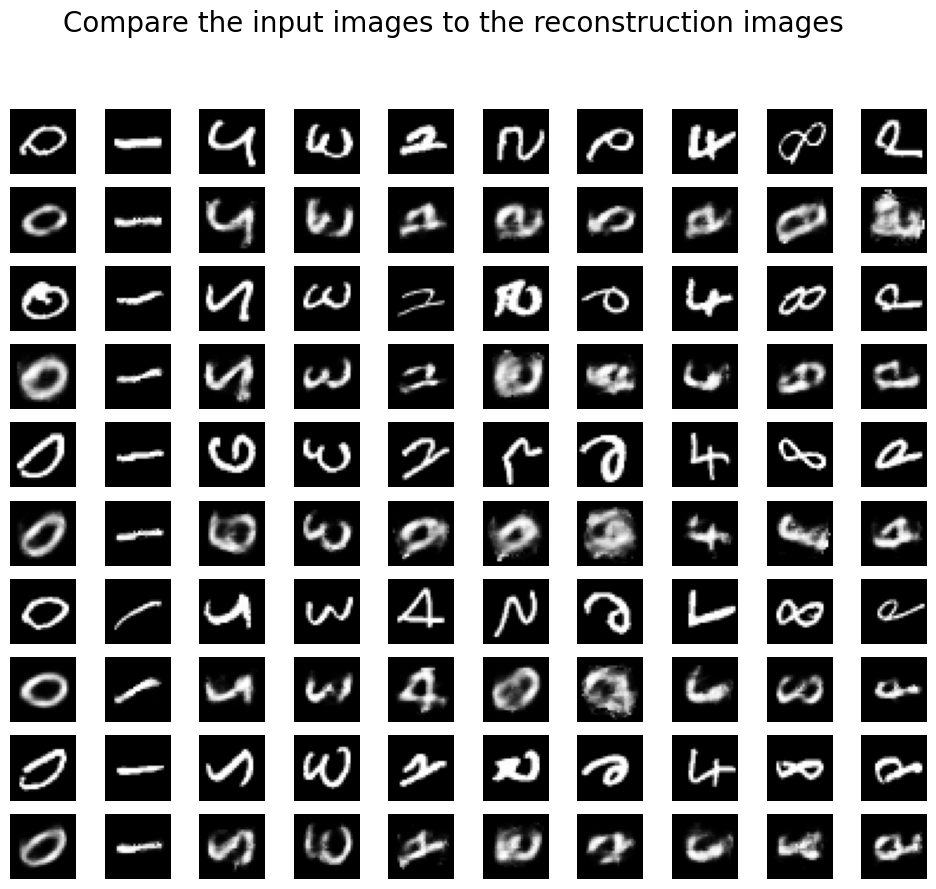

In [356]:
# Randomly selected 8 images of the input and compare them to the outputs
rows = 10
columns = 10
fig = plt.figure(figsize=(12, 10))
fig.suptitle('Compare the input images to the reconstruction images', fontsize = 20)
for i in range(5):
        for j in range(5):
                fig.add_subplot(rows, columns, int(j + i*20 + 1)) # 0, 1, 2, 3, 4, 10, 11, 12, 13, 14, 20, 21, 22, 23, 24
                plt.imshow(test[total_list[j + i*10]].reshape(28, 28), cmap="gray")
                plt.axis('off')
                fig.add_subplot(rows, columns, int(j + i*20 + 11))
                plt.imshow(test_output[total_list[j + i*10]].reshape(28, 28), cmap="gray")
                plt.axis('off')

                fig.add_subplot(rows, columns, int(j + i*20 + 6))
                plt.imshow(validate[total_list[j + i*10 + 5]].reshape(28, 28), cmap="gray")
                plt.axis('off')
                fig.add_subplot(rows, columns, int(j + i*20 + 16))
                plt.imshow(validate_output[total_list[j + i*10 + 5]].reshape(28, 28), cmap="gray")
                plt.axis('off')

plt.savefig('problem2_reconstruction_outputs.png')
plt.show()